<a href="https://colab.research.google.com/github/aaronjoel/DeepUnderstandingOfDeepLearning/blob/main/DUDLRegularDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as mb
mb.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Create the data

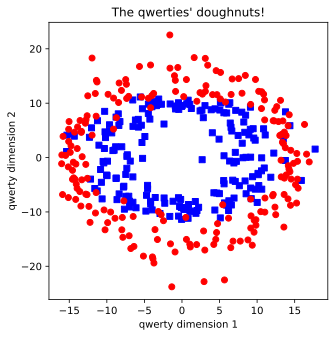

In [2]:
# create data
nPerClust = 200

th = np.linspace(0, 4*np.pi, nPerClust)
r1 = 10
r2 = 15

# generate data
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]

b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]


# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatenate into a matrix
data_np = np.hstack((a, b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ro')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Separate the data into DataLoaders

In [3]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# Convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [4]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate, numHiddens=128):
        super().__init__()

        ## layers
        self.input = nn.Linear(2, numHiddens)
        self.hidden = nn.Linear(numHiddens, numHiddens)
        self.output = nn.Linear(numHiddens, 1)

        ## parameters
        self.lr = dropoutRate

    ## Forward pass
    def forward(self, x):
        # pass the data through the input layer
        x = F.relu(self.input(x))

        # dropout after input layer
        x = F.dropout(x, p=self.lr, training=self.training)

        # Pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # dropout after hidden layer
        x = F.dropout(x, p=self.lr, training=self.training)

        # output layer
        x = self.output(x)

        # no dropout here!
        return x

In [5]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10, 2))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.1738],
        [-0.0100],
        [-0.1533],
        [-0.4282],
        [ 0.1859],
        [-0.1855],
        [-0.0243],
        [-0.2521],
        [-0.0618],
        [-0.0247]], grad_fn=<AddmmBackward0>)

## Functions to create and train the net

In [6]:
def createANewModel(dropoutRate, numHiddens = 64, lr=0.002):

    # grab an instance of the model class
    ANNQC = theModelClass(dropoutRate, numHiddens)

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=lr)

    return ANNQC, lossfun, optimizer

In [7]:
# train the model

# training parameter
num_epochs = 1000

# NOTE: This time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC, lossfun, optimizer):
    # Initialise accuracies as empties (not storing losses here)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(num_epochs):

        # switch training mode on (is this the right place for this code??)
        ANNQC.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yhat = ANNQC(X)
            loss = lossfun(yhat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100*torch.mean(((yhat > 0) == y).float()).item())
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # test accuracy
        ANNQC.eval()  # switch training off
        X, y = next(iter(test_loader))  # Extract X, y from test dataloader
        yhat = ANNQC(X)
        testAcc.append(100*torch.mean(((yhat > 0) == y).float()).item())

    # Function output
    return trainAcc, testAcc


In [8]:
# create a model
dropoutRate = .0
ANNQC, lossfun, optimizer = createANewModel(dropoutRate)

# train the model (note the inputs!)
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

In [9]:
def smooth(x, k=5, isSmooth=True):
    if isSmooth:
        return np.convolve(x, np.ones(k)/k, mode='same')
    else:
        return x

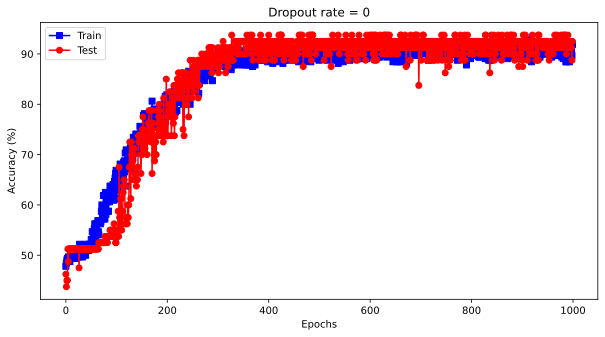

In [10]:
# plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(smooth(trainAcc, isSmooth=False), 'bs-')
plt.plot(smooth(testAcc, isSmooth=False), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title('Dropout rate = %g' %dropoutRate)

plt.show()

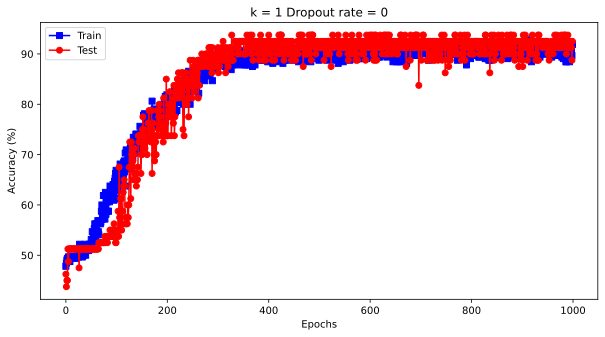

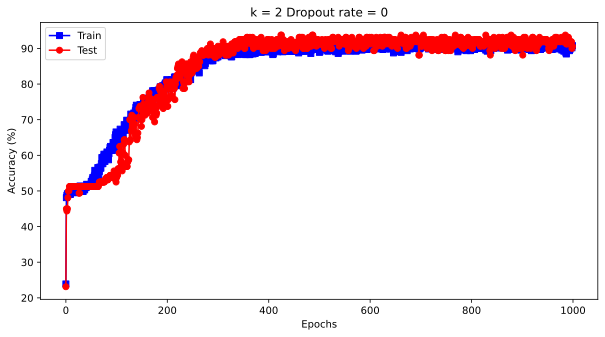

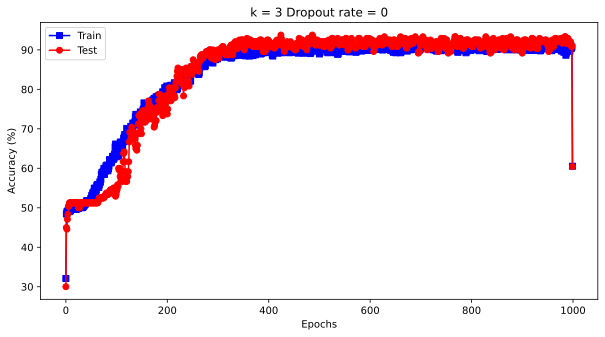

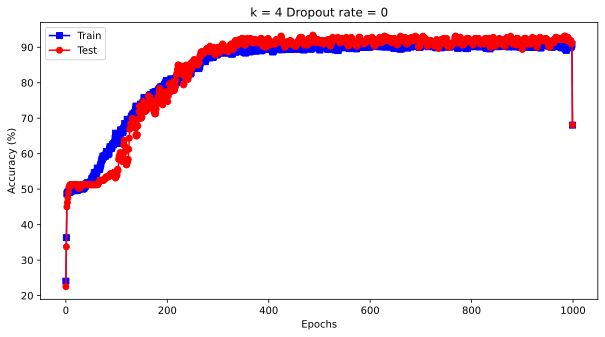

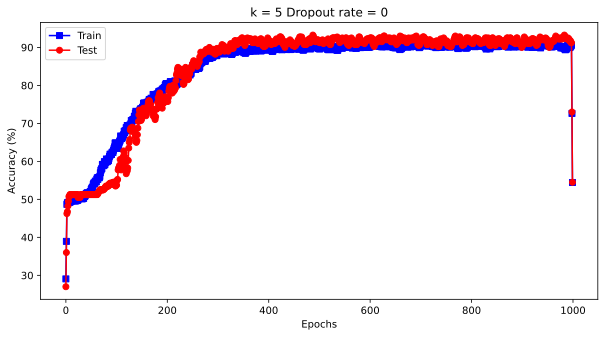

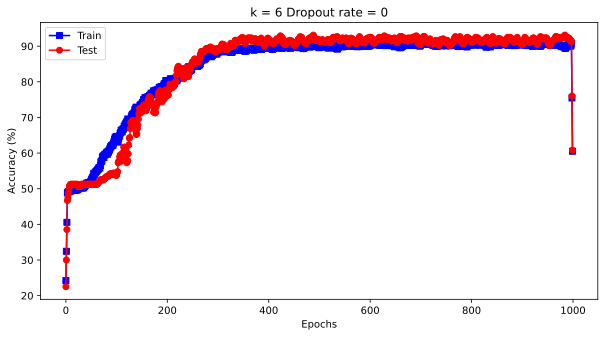

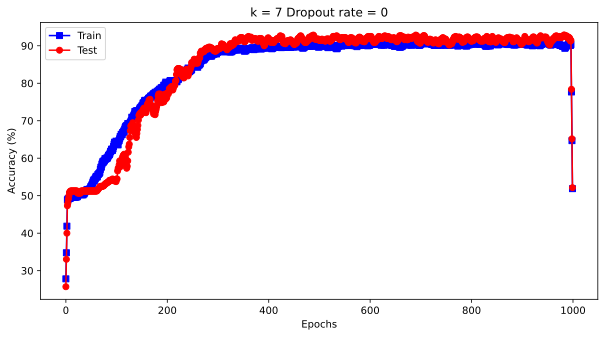

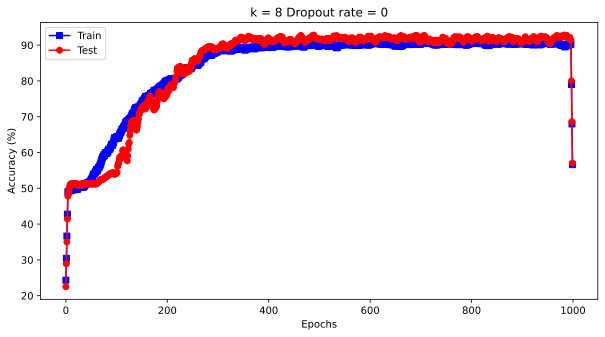

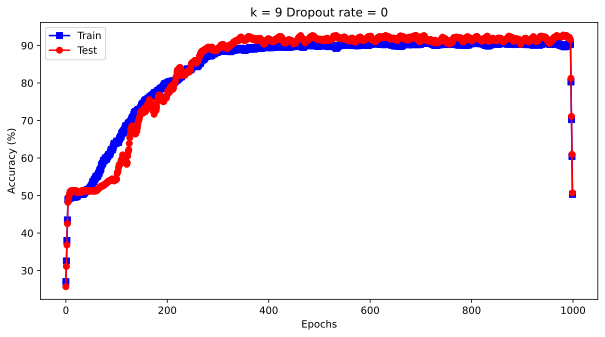

In [11]:
for k in range(1, 10):
    # plot the results
    fig = plt.figure(figsize=(10, 5))

    plt.plot(smooth(trainAcc, k=k, isSmooth=True), 'bs-')
    plt.plot(smooth(testAcc, k=k, isSmooth=True), 'ro-')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend(['Train', 'Test'])
    plt.title('k = %d Dropout rate = %g' %(k, dropoutRate))

    plt.show()

## Now for the experiment

In [12]:
# Run an experiment (note: takes ~3.5 mins)

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

    # store the accuracies for the last 100 epochs
    results[di, 0] = np.mean(trainAcc[-100:])
    results[di, 1] = np.mean(testAcc[-100:])

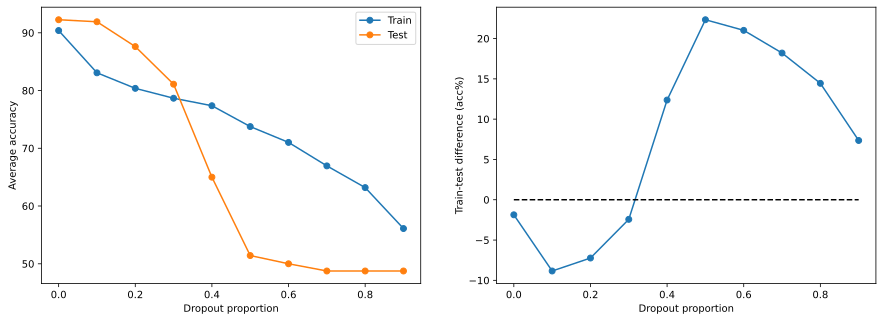

In [13]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

## Effect of smoothing parameter k

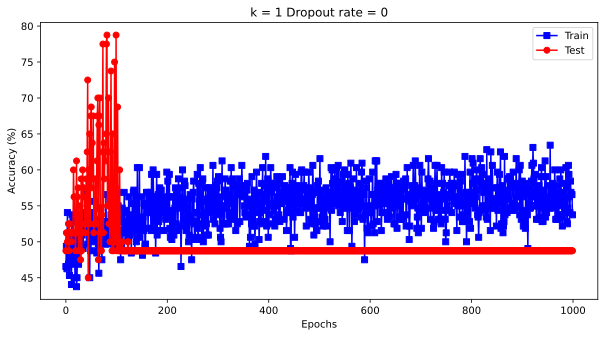

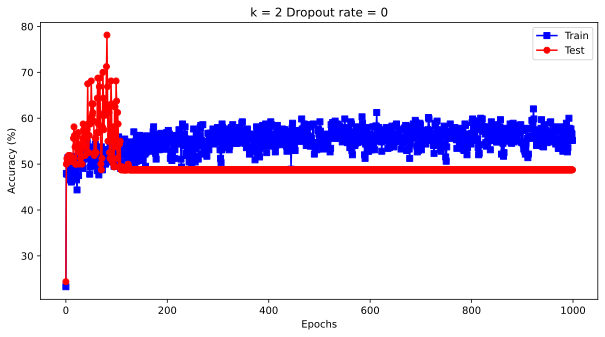

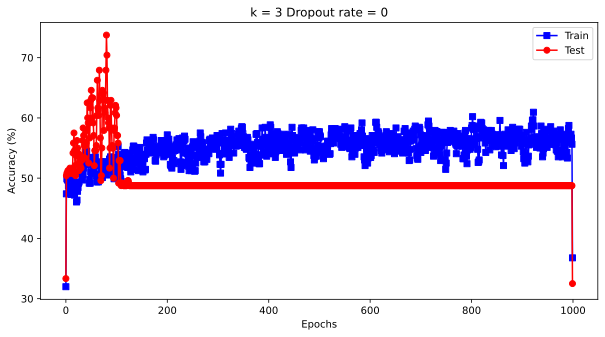

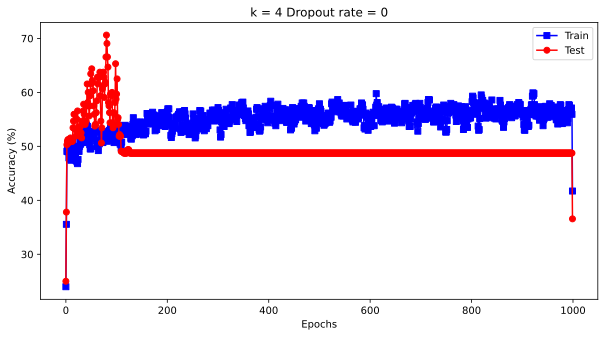

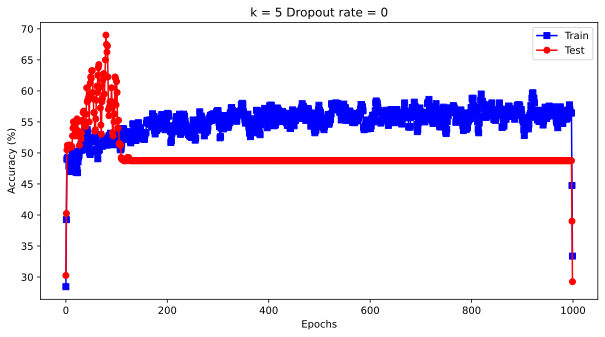

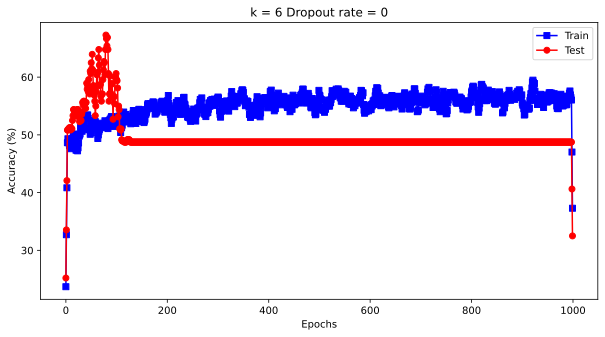

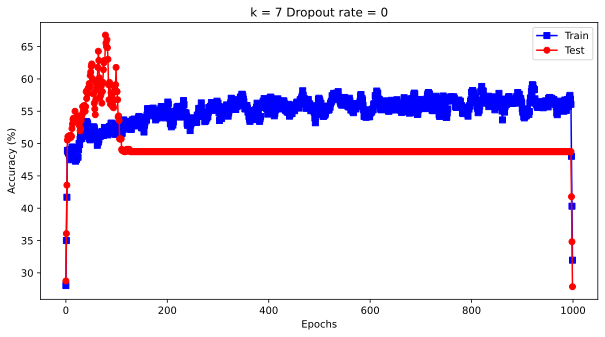

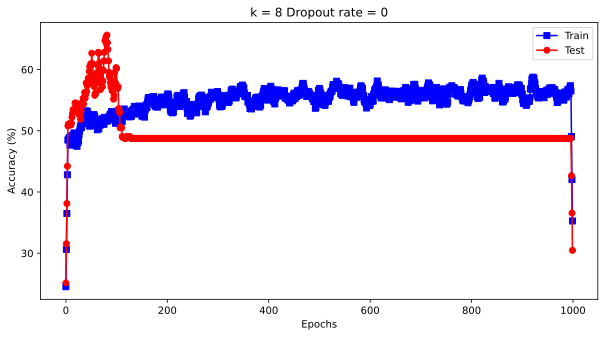

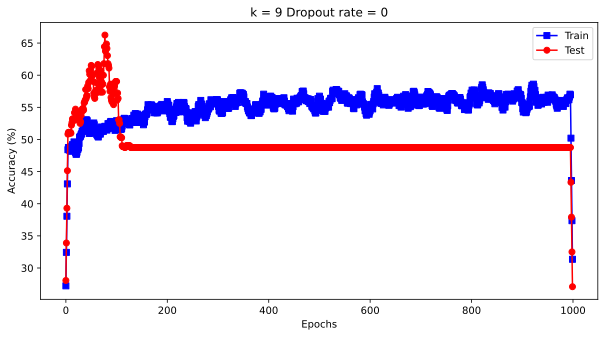

In [14]:
for k in range(1, 10):
    # plot the results
    fig = plt.figure(figsize=(10, 5))

    plt.plot(smooth(trainAcc, k=k, isSmooth=True), 'bs-')
    plt.plot(smooth(testAcc, k=k, isSmooth=True), 'ro-')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend(['Train', 'Test'])
    plt.title('k = %d Dropout rate = %g' %(k, dropoutRate))

    plt.show()

### With numHiddens = 64

In [15]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di], numHiddens=64)
    trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

    # store the accuracies for the last 100 epochs
    results[di, 0] = np.mean(trainAcc[-100:])
    results[di, 1] = np.mean(testAcc[-100:])

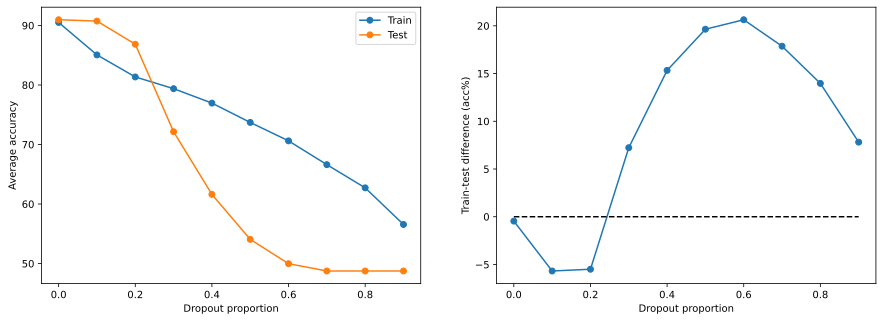

In [16]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

### numHiddens = 256

In [17]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di], numHiddens=256)
    trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

    # store the accuracies for the last 100 epochs
    results[di, 0] = np.mean(trainAcc[-100:])
    results[di, 1] = np.mean(testAcc[-100:])

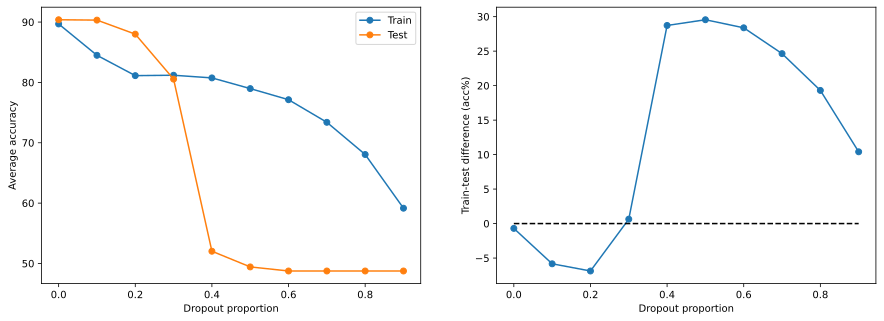

In [18]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Dropout example 2
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [19]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as mb
mb.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [20]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0   ## This is not necessary
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [21]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# finally, translate into dataloader object
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [22]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate, numHiddens):
        super().__init__()

        ### layers
        self.input   = nn.Linear(4, numHiddens)
        self.hidden  = nn.Linear(numHiddens, numHiddens)
        self.output  = nn.Linear(numHiddens, 3)

        # parameters
        self.dr = dropoutRate

    # Forward pass
    def forward(self, x):

        # input
        x = F.relu( self.input(x) )
        x = F.dropout(x, p=self.dr, training=self.training) # switch dropout off during .eval()

        # Hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x, p=self.dr, training=self.training)

        # Output
        x = self.output(x)
        return x

In [23]:
# test the model
tmpnet = theModelClass(dropoutRate=.25, numHiddens=12)

# run some random data through
tmpdata = torch.randn((10, 4))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.0355,  0.1457,  0.2431],
        [-0.1596,  0.0252,  0.1734],
        [-0.2384, -0.0164,  0.2702],
        [-0.2151,  0.0272,  0.2303],
        [-0.0685,  0.1349,  0.2656],
        [-0.1770,  0.0516,  0.1624],
        [ 0.0593,  0.1908,  0.1800],
        [ 0.0838,  0.1318,  0.2377],
        [-0.1453,  0.0519,  0.2563],
        [-0.2986, -0.0171,  0.1856]], grad_fn=<AddmmBackward0>)

In [24]:
# A function that creates the ANN model
def createANewModel(dropoutRate, numHiddens = 64, lr=0.005):

    # grab an instance of the model class
    ANNiris = theModelClass(dropoutRate, numHiddens)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=lr)

    return ANNiris, lossfun, optimizer

In [25]:
# train the model

# global parameter
num_epochs = 500

def trainTheModel():

    # initialise accuracies as empties (not storing losses here)
    trainAcc  = []
    testAcc   = []

    # loop over epochs
    for epochi in range(num_epochs):

        # switch learning on
        ANNiris.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yhat = ANNiris(X)
            loss = lossfun(yhat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean((torch.argmax(yhat, axis=1) == y).float()).item())
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        ANNiris.eval()  # switch training off
        X, y = next(iter(test_loader))  # Extract X, y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append( 100*torch.mean((predlabels == y).float()).item())

    # function output
    return trainAcc, testAcc

In [26]:
# create a model
dropoutRate = .0
ANNiris, lossfun, optimizer = createANewModel(dropoutRate, numHiddens=12)

# train the model
trainAcc, testAcc = trainTheModel()

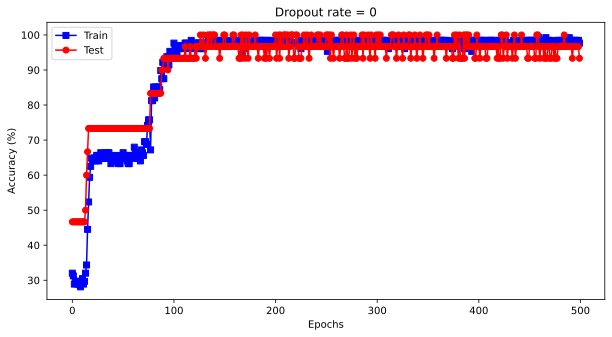

In [27]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutRate)

plt.show()

In [28]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNiris,lossfun,optimizer = createANewModel(dropoutRates[di], numHiddens=12)
  trainAcc,testAcc = trainTheModel()

  # store accuracies
  results[di,0] = np.mean(trainAcc[-50:])
  results[di,1] = np.mean(testAcc[-50:])


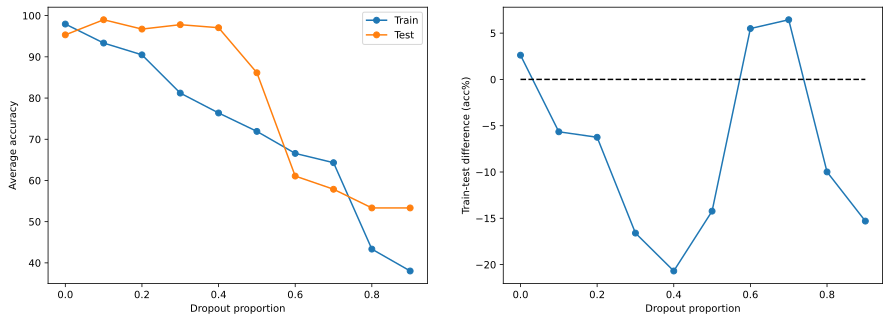

In [29]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

### Removing ReLU from the network

In [30]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate, numHiddens):
        super().__init__()

        ### layers
        self.input   = nn.Linear(4, numHiddens)
        self.hidden  = nn.Linear(numHiddens, numHiddens)
        self.output  = nn.Linear(numHiddens, 3)

        # parameters
        self.dr = dropoutRate

    # Forward pass
    def forward(self, x):

        # input
        x = self.input(x)
        x = F.dropout(x, p=self.dr, training=self.training) # switch dropout off during .eval()

        # Hidden
        x = self.hidden(x)
        x = F.dropout(x, p=self.dr, training=self.training)

        # Output
        x = self.output(x)
        return x

In [31]:
# test the model
tmpnet = theModelClass(dropoutRate=.25, numHiddens=12)

# run some random data through
tmpdata = torch.randn((10, 4))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.0838,  0.0641, -0.3146],
        [ 0.0686,  0.4419,  0.0316],
        [ 0.1674,  0.2979, -0.2309],
        [ 0.0521,  0.2210, -0.4726],
        [ 0.0535,  0.5202, -0.2249],
        [ 0.0512,  0.4178, -0.1546],
        [-0.1091,  0.3663, -0.1576],
        [ 0.0210,  0.5245,  0.1028],
        [ 0.1824,  0.3562,  0.0981],
        [ 0.0701,  0.2958, -0.1978]], grad_fn=<AddmmBackward0>)

In [32]:
# A function that creates the ANN model
def createANewModel(dropoutRate, numHiddens = 64, lr=0.005):

    # grab an instance of the model class
    ANNiris = theModelClass(dropoutRate, numHiddens)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=lr)

    return ANNiris, lossfun, optimizer

In [33]:
# train the model

# global parameter
num_epochs = 500

def trainTheModel():

    # initialise accuracies as empties (not storing losses here)
    trainAcc  = []
    testAcc   = []

    # loop over epochs
    for epochi in range(num_epochs):

        # switch learning on
        ANNiris.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yhat = ANNiris(X)
            loss = lossfun(yhat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean((torch.argmax(yhat, axis=1) == y).float()).item())
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy
        ANNiris.eval()  # switch training off
        X, y = next(iter(test_loader))  # Extract X, y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append( 100*torch.mean((predlabels == y).float()).item())

    # function output
    return trainAcc, testAcc

In [34]:
# create a model
dropoutRate = .0
ANNiris, lossfun, optimizer = createANewModel(dropoutRate, numHiddens=12)

# train the model
trainAcc, testAcc = trainTheModel()

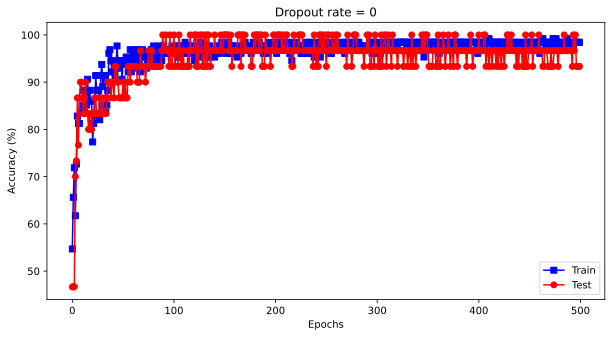

In [35]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutRate)

plt.show()

In [36]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNiris,lossfun,optimizer = createANewModel(dropoutRates[di], numHiddens=12)
  trainAcc,testAcc = trainTheModel()

  # store accuracies
  results[di,0] = np.mean(trainAcc[-50:])
  results[di,1] = np.mean(testAcc[-50:])


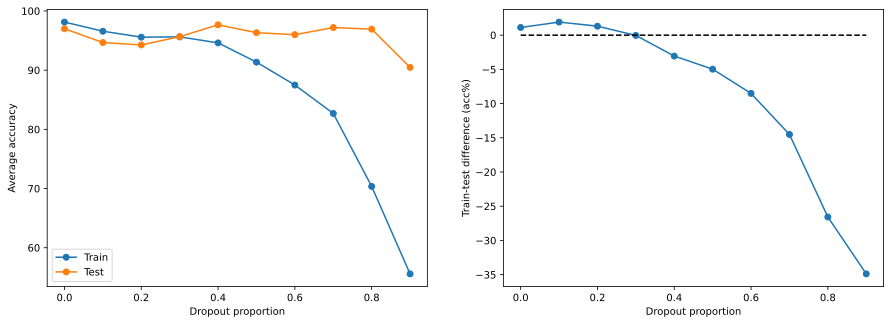

In [37]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
prob = .5

dropout = nn.Dropout(p=prob)
x = torch.ones(10)
x

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
y = dropout(x)
print(x)
print(y * (1 - prob))
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 0.])
tensor(1.2000)


In [41]:
1 - prob

0.5

In [42]:
y * (1 - prob)

tensor([0., 1., 1., 1., 1., 0., 1., 0., 1., 0.])

In [43]:
dropout.eval()
y = dropout(x)
y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
torch.mean(y)

tensor(1.)

In [45]:
dropout.eval()
y = F.dropout(x)
y

tensor([2., 0., 0., 2., 2., 0., 0., 2., 0., 0.])

In [46]:
torch.mean(y)

tensor(0.8000)

In [47]:
y = F.dropout(x, training=False)
y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [48]:
F.dropout(x, training=True)

tensor([0., 2., 2., 2., 0., 2., 2., 0., 2., 2.])

In [49]:
dropout.eval()
y = dropout(x)
y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [50]:
dropout.train()
y = dropout(x)
y

tensor([2., 0., 0., 2., 2., 2., 2., 0., 2., 0.])

## Regularization

In [51]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

In [52]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [53]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
#labels[iris.species == 'setosa] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species=='virginica'] = 2


In [54]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# create dataloader objects
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [55]:
def createANewModel(nHiddens1=64, nHiddens2=64, lr=0.005):

    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4, nHiddens1),            # input layer
        nn.ReLU(),                          # activation unit
        nn.Linear(nHiddens1, nHiddens2),    # hidden layer
        nn.ReLU(),                          # activation
        nn.Linear(nHiddens2, 3)
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=lr)

    return ANNiris, lossfun, optimizer

In [56]:
# explore the model in more detail
tmpmodel = createANewModel()[0]

# print the model architecture
print(tmpmodel)

# print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [57]:
num_epochs = 1000

def trainTheModel(L1lambda):

    # initialise accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # count the total number of weights in the model
    nweights = 0
    for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()

    # loop over epochs
    for epochi in range(num_epochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yhat = ANNiris(X)
            loss = lossfun(yhat, y)

            ### add L1 term
            L1_term = torch.tensor(0., requires_grad=True)

            # sum up all abs(weights)
            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # add to loss term
            loss = loss + L1lambda * L1_term / nweights

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean((torch.argmax(yhat, axis=1) == y).float()).item() )
            batchLoss.append( loss.item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        X, y = next(iter(test_loader)) # extract X, y from test dataloader
        predlabels = torch.argmax( ANNiris(X), axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return trainAcc, testAcc, losses

In [59]:

# create a model
ANNiris, lossfun, optimizer = createANewModel()

L1lambda = 0.001
# train the model
trainAcc, testAcc, losses = trainTheModel(L1lambda=L1lambda)

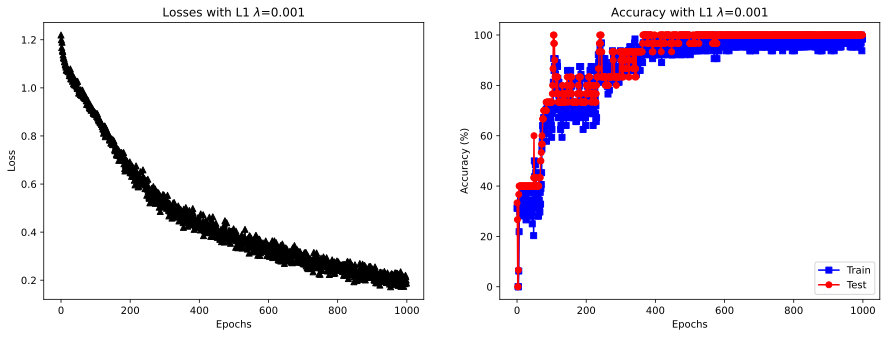

In [60]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc, 'bs-')
ax[1].plot(testAcc, 'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))

plt.show()

In [61]:

# create a model
ANNiris, lossfun, optimizer = createANewModel()

L1lambda = 0.01
# train the model
trainAcc, testAcc, losses = trainTheModel(L1lambda=L1lambda)

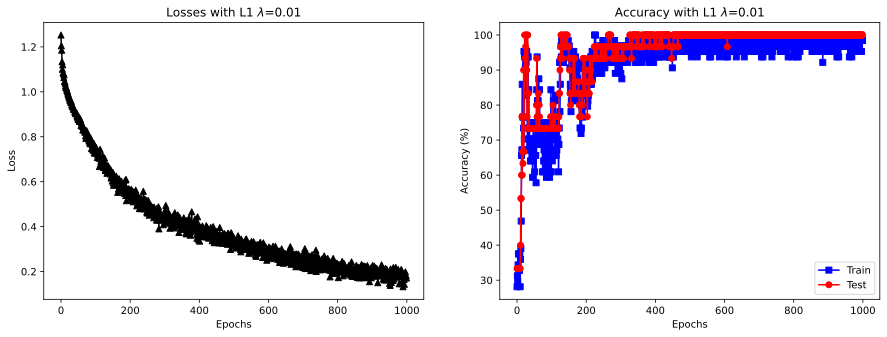

In [62]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc, 'bs-')
ax[1].plot(testAcc, 'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))

plt.show()

In [63]:

# create a model
ANNiris, lossfun, optimizer = createANewModel()

L1lambda = 0.1
# train the model
trainAcc, testAcc, losses = trainTheModel(L1lambda=L1lambda)

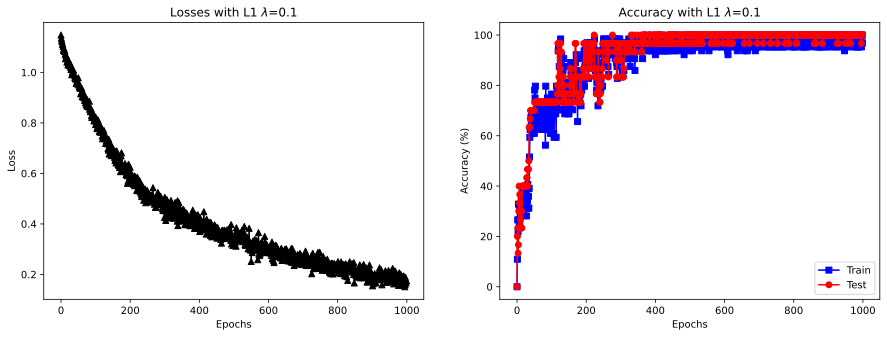

In [64]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(trainAcc, 'bs-')
ax[1].plot(testAcc, 'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))

plt.show()

## Parametric Experiment

In [65]:
# range of L1 regularization amounts
L1lambda = np.linspace(0, .005, 10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((num_epochs, len(L1lambda)))
accuracyResultsTest  = np.zeros((num_epochs, len(L1lambda)))

# loop over batch sizes
for li in range(len(L1lambda)):

    # create and train a model
    ANNiris, lossfun, optimizer = createANewModel()
    trainAcc, testAcc, losses = trainTheModel(L1lambda=L1lambda[li])

    # store the data
    accuracyResultsTrain[:, li] = smooth(trainAcc, k=10)
    accuracyResultsTest[:, li] = smooth(testAcc, k=10)

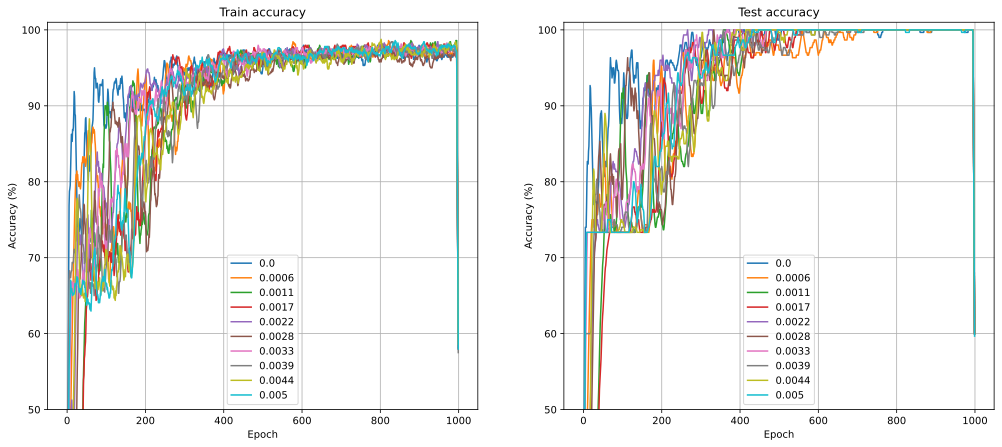

In [66]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i, 4) for i in L1lambda]

# Common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.show()

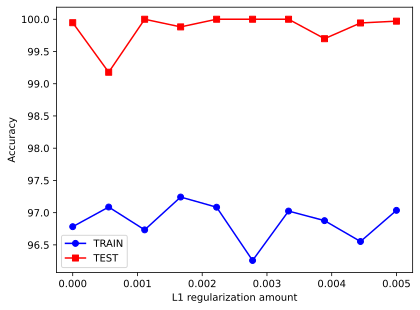

In [67]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Manual L2 regularizer

In [69]:
torch.square(torch.tensor(10))

tensor(100)

In [70]:
num_epochs = 1000

def trainTheModel(L2lambda):

    # initialise accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # count the total number of weights in the model
    nweights = 0
    for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()

    # loop over epochs
    for epochi in range(num_epochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yhat = ANNiris(X)
            loss = lossfun(yhat, y)

            ### add L1 term
            L2_term = torch.tensor(0., requires_grad=True)

            # sum up all abs(weights)
            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L2_term = L2_term + torch.sum(torch.square(weight))

            # add to loss term
            loss = loss + L2lambda * L2_term / nweights

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean((torch.argmax(yhat, axis=1) == y).float()).item() )
            batchLoss.append( loss.item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        X, y = next(iter(test_loader)) # extract X, y from test dataloader
        predlabels = torch.argmax( ANNiris(X), axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return trainAcc, testAcc, losses

In [71]:
# create a model
ANNiris, lossfun, optimizer = createANewModel()

L2lambda = 0.001
# train the model
trainAcc, testAcc, losses = trainTheModel(L2lambda=L2lambda)

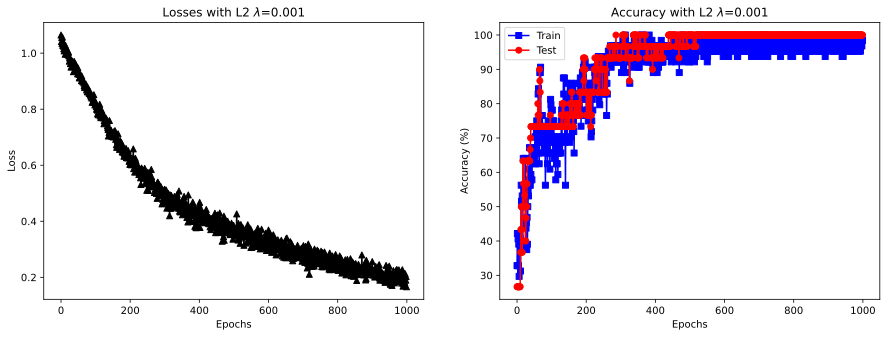

In [73]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
ax[1].plot(trainAcc, 'bs-')
ax[1].plot(testAcc, 'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))

plt.show()

In [74]:
# range of L2 regularization amounts
L2lambda = np.linspace(0, .05, 10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((num_epochs, len(L2lambda)))
accuracyResultsTest  = np.zeros((num_epochs, len(L2lambda)))

# loop over batch sizes
for li in range(len(L2lambda)):

    # create and train a model
    ANNiris, lossfun, optimizer = createANewModel()
    trainAcc, testAcc, losses = trainTheModel(L2lambda=L2lambda[li])

    # store the data
    accuracyResultsTrain[:, li] = smooth(trainAcc, k=10)
    accuracyResultsTest[:, li] = smooth(testAcc, k=10)

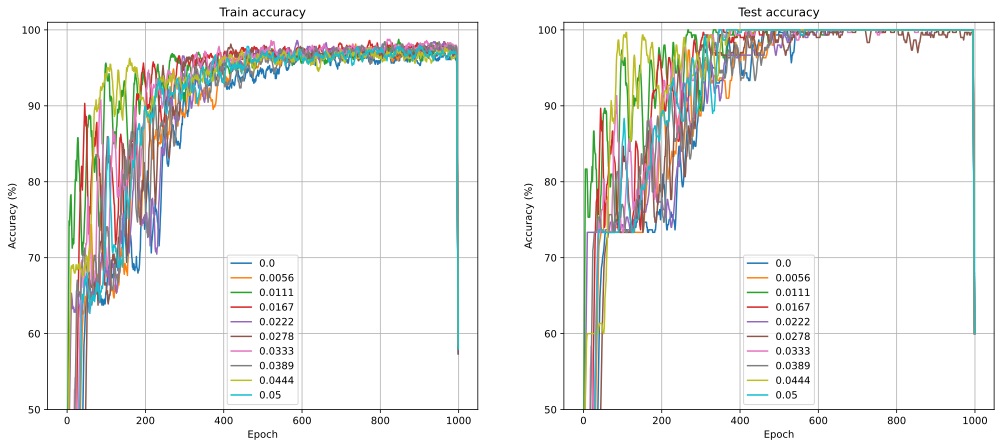

In [75]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i, 4) for i in L2lambda]

# Common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.show()

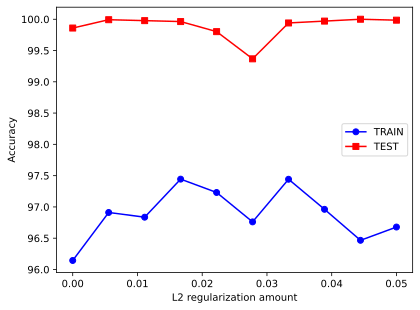

In [76]:
# show average accuracy by L1 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L2lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L2lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Combined L1+L2 regularisation

In [77]:
from re import L
num_epochs = 1000

def trainTheModel(L1lambda, L2lambda):

    # initialise accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # count the total number of weights in the model
    nweights = 0
    for pname, weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            nweights += weight.numel()

    # loop over epochs
    for epochi in range(num_epochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yhat = ANNiris(X)
            loss = lossfun(yhat, y)

            ### add L1 term
            L1_term = torch.tensor(0., requires_grad=True)
            L2_term = torch.tensor(0., requires_grad=True)

            # sum up all abs(weights)
            for pname, weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
                    L2_term = L2_term + torch.sum(torch.square(weight))

            # add to loss term
            loss = loss + L1lambda * L1_term / nweights
            loss = loss + L2lambda * L2_term / nweights

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean((torch.argmax(yhat, axis=1) == y).float()).item() )
            batchLoss.append( loss.item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        X, y = next(iter(test_loader)) # extract X, y from test dataloader
        predlabels = torch.argmax( ANNiris(X), axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return trainAcc, testAcc, losses

In [78]:
# create a model
ANNiris, lossfun, optimizer = createANewModel()

L2lambda = 0.01
L1lambda = 0.01
# train the model
trainAcc, testAcc, losses = trainTheModel(L1lambda=L1lambda, L2lambda=L2lambda)

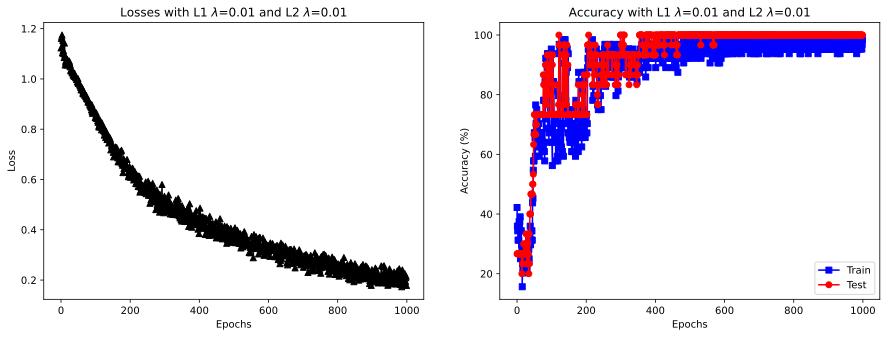

In [79]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda) + ' and L2 $\lambda$=' + str(L2lambda))
ax[1].plot(trainAcc, 'bs-')
ax[1].plot(testAcc, 'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L2lambda) + ' and L2 $\lambda$=' + str(L2lambda))

plt.show()